In [1]:
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

--2024-01-16 08:07:34--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2024-01-16 08:07:34--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.03MB/s    in 4m 44s  

2024-01-16 08:12:19 (5.10 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



In [2]:
!unzip glove.twitter.27B.zip

Archive:  glove.twitter.27B.zip
  inflating: glove.twitter.27B.25d.txt  
  inflating: glove.twitter.27B.50d.txt  
  inflating: glove.twitter.27B.100d.txt  
  inflating: glove.twitter.27B.200d.txt  


In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

Tensorflow version 2.12.0
Running on TPU  ['10.29.217.66:8470']


In [5]:
import re
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import pandas as pd

twitter_df = pd.read_csv("/content/Twitter_Data.csv")
reddit_df = pd.read_csv("/content/Reddit_Data.csv")

twitter_X = twitter_df['clean_text']
twitter_y = twitter_df['category']

reddit_X = reddit_df['clean_comment']
reddit_y = reddit_df['category']

X = pd.concat([twitter_X, reddit_X], ignore_index=True)
y = pd.concat([twitter_y, reddit_y], ignore_index=True)

y = y.map({-1: 0, 0: 1, 1: 2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train = X_train.astype(str).fillna("")
X_test = X_test.astype(str).fillna("")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

vocab_size = len(tokenizer.word_index) + 1

X_train_tokenized = tokenizer.texts_to_sequences(X_train)
X_test_tokenized = tokenizer.texts_to_sequences(X_test)



max_len_train = max(len(seq) for seq in X_train_tokenized)
max_len_test = max(len(seq) for seq in X_test_tokenized)
max_len = max(max_len_train, max_len_test)

X_train_padded = pad_sequences(X_train_tokenized, padding="post", maxlen=max_len)
X_test_padded = pad_sequences(X_test_tokenized, padding="post", maxlen=max_len)

In [6]:
custom_lr = 0.01
custom_optimizer = Adam(learning_rate=custom_lr)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=custom_lr,
  decay_steps=10000,
  decay_rate=0.9
)

embeddings_index = {}
f = open('glove.twitter.27B.100d.txt', encoding='utf-8')  # Adjust filename as needed
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256 * tpu_strategy.num_replicas_in_sync

with tpu_strategy.scope():
  model = Sequential()
  model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False))
  model.add(Bidirectional(LSTM(128, return_sequences=True)))
  model.add(Dropout(0.2))
  model.add(Bidirectional(LSTM(64)))
  model.add(Dropout(0.2))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(3, activation='softmax'))

  model.compile(optimizer=custom_optimizer,
         loss='sparse_categorical_crossentropy',
         metrics=['accuracy'])
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         13051900  
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4

https://projector.tensorflow.org/

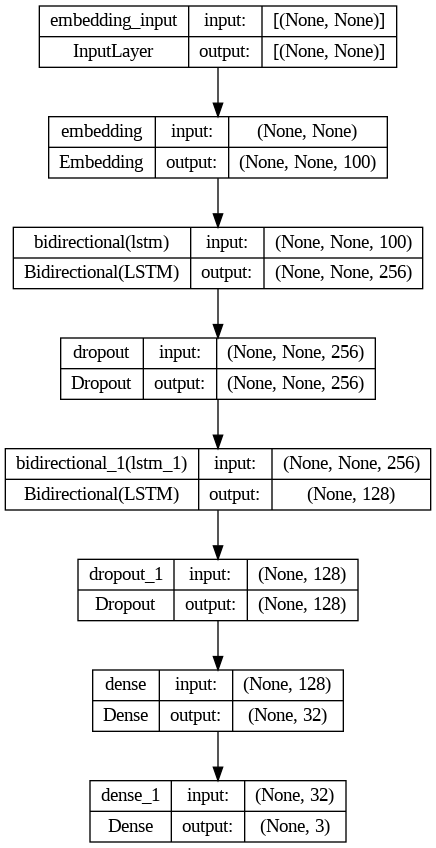

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model,

           to_file='keras_model_plot.png',

           show_shapes=True,

           show_layer_names=True)

In [7]:
history = model.fit(X_train_padded, y_train,
                    validation_data=(X_test_padded, y_test),
                    epochs=10,
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=len(X_train_padded) // BATCH_SIZE)

Epoch 1/10
87/87 [==============================] - 1410s 16s/step - loss: 0.8322 - accuracy: 0.6241 - val_loss: 0.6038 - val_accuracy: 0.7516
Epoch 2/10
87/87 [==============================] - 1369s 15s/step - loss: 0.4516 - accuracy: 0.8281 - val_loss: 0.3194 - val_accuracy: 0.8912
Epoch 3/10
87/87 [==============================] - 1347s 15s/step - loss: 0.2516 - accuracy: 0.9175 - val_loss: 0.2175 - val_accuracy: 0.9305
Epoch 4/10
87/87 [==============================] - 1347s 15s/step - loss: 0.1888 - accuracy: 0.9400 - val_loss: 0.1808 - val_accuracy: 0.9447
Epoch 5/10
87/87 [==============================] - 1347s 15s/step - loss: 0.1513 - accuracy: 0.9527 - val_loss: 0.1566 - val_accuracy: 0.9512
Epoch 6/10
87/87 [==============================] - 1347s 15s/step - loss: 0.1295 - accuracy: 0.9597 - val_loss: 0.1487 - val_accuracy: 0.9538
Epoch 7/10
87/87 [==============================] - 1347s 15s/step - loss: 0.1172 - accuracy: 0.9640 - val_loss: 0.1678 - val_accuracy: 0.9484

In [39]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['accuracy'], mode='lines', name='Train', line=dict(color='lime')))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_accuracy'], mode='lines', name='Test', line=dict(color='cyan')))

fig.update_layout(title='Model Accuracy Over Epochs',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Accuracy'),
                  legend=dict(x=0, y=1, traceorder='normal'),
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  font=dict(color='white'))
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['loss'], mode='lines', name='Train', line=dict(color='lime')))
fig.add_trace(go.Scatter(x=history.epoch, y=history.history['val_loss'], mode='lines', name='Test', line=dict(color='cyan')))

fig.update_layout(title='Model Loss Over Epochs',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Loss'),
                  legend=dict(x=0, y=1, traceorder='normal'),
                  paper_bgcolor='black',
                  plot_bgcolor='black',
                  font=dict(color='white'))
fig.show()


In [34]:
model.save('sentiment_analysis_model.h5')

In [35]:
from tensorflow.keras.models import load_model
loaded_model = load_model('sentiment_analysis_model.h5')

In [50]:
def preprocess_input_text(input_text, tokenizer, max_len):
    input_text = re.sub(r'https?://\S+', '', input_text)
    input_text = re.sub(r'\n', ' ', input_text)
    input_text = re.sub(r'\s+', ' ', input_text).strip()
    input_tokenized = tokenizer.texts_to_sequences([input_text])
    input_padded = pad_sequences(input_tokenized, padding="post", maxlen=max_len)

    return input_padded

def predict_sentiment(input_text, model, tokenizer, max_len):
    processed_input = preprocess_input_text(input_text, tokenizer, max_len)
    predictions = model.predict(processed_input)
    predicted_class = np.argmax(predictions)
    return predicted_class
user_input = input("Enter text for sentiment prediction: ")
predicted_class = predict_sentiment(user_input, model, tokenizer, max_len)

if predicted_class == 0:
    print("Predicted Sentiment: Negative")
elif predicted_class == 1:
    print("Predicted Sentiment: Neutral")
elif predicted_class == 2:
    print("Predicted Sentiment: Positive")

Enter text for sentiment prediction: "I absolutely loved the new movie! The plot was engaging, and the performances were outstanding. Can't wait to watch it again!"
1/1 [==============================] - 1s 796ms/step
Predicted Sentiment: Positive
